<div align='left'>
    <h1 style="color: #FFA500; font-size: 36px; font-weight: bold;">[LAB 08] SỰ PHÂN TÍCH NHÓM (TT)</h1>
</div>

> **Sinh viên:** Nguyễn Công Hoài Nam  
> **Mã số sinh viên:** 21280099

## **Mô hình hỗn hợp Gaussian**

Import thư viện

In [939]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

Chuẩn bị dữ liệu

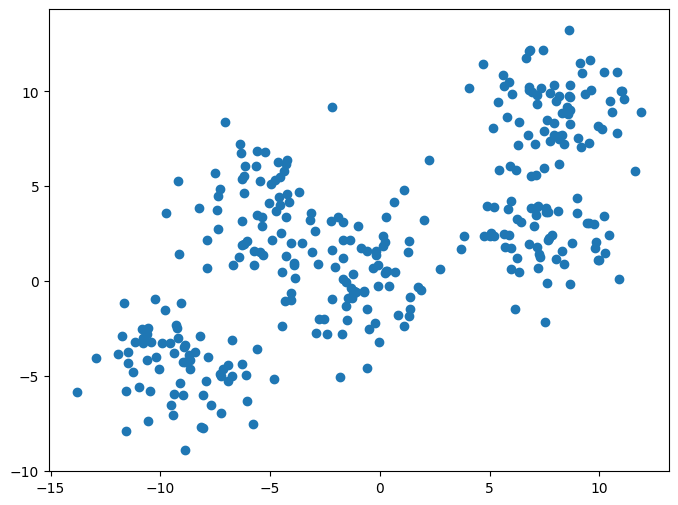

In [940]:
np.random.seed(234)
x,y=make_blobs(n_samples=330, centers=5,cluster_std=1.84)
plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1])
plt.show()

Xác định `GMM` và điều chỉnh nó trên dữ liệu x.
 
Chia dữ liệu thành 5 cụm, ta thu được các tâm của cụm như sau

In [941]:
gm= GaussianMixture(n_components=5).fit(x)
centers=gm.means_
print(centers)

[[-5.55836831  3.87299888]
 [ 7.28418475  2.56387124]
 [-0.90246061  0.16230294]
 [-9.18288987 -4.47852917]
 [ 8.11454324  9.24741885]]


Vẽ các tâm này và các điểm dữ liệu

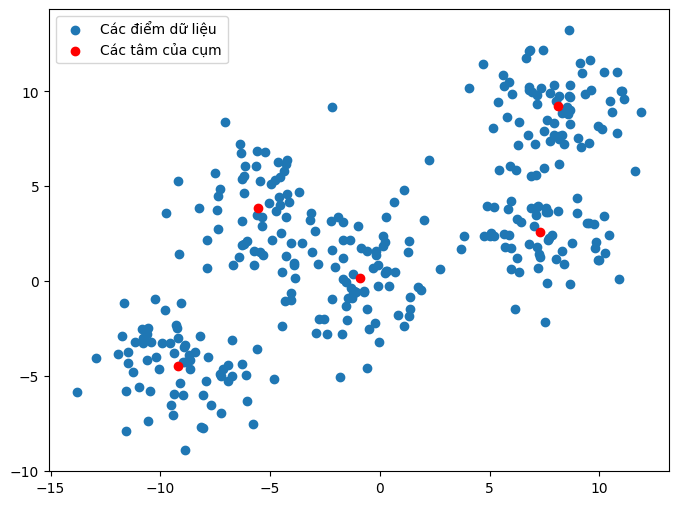

In [942]:
plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1],label="Các điểm dữ liệu")
plt.scatter(centers[:,0],centers[:,1],c='r',label="Các tâm của cụm")
plt.legend()
plt.show()

Dự đoán dữ liệu x với mô hình được huấn luyện, gom nhóm các phần tử và trực quan hóa các cụm trong biểu đồ

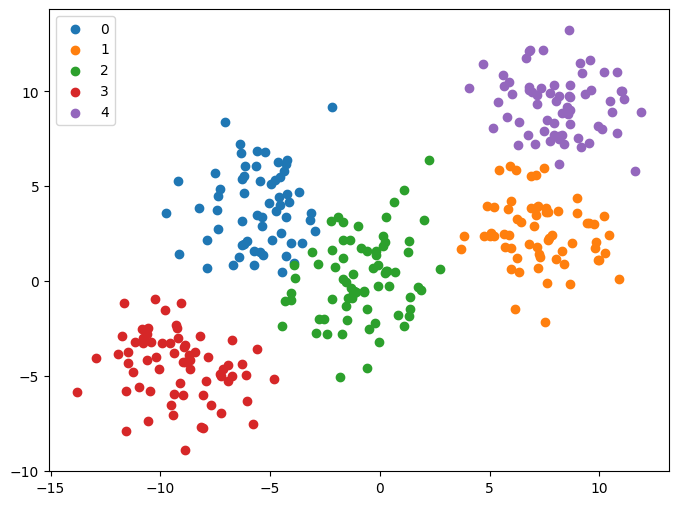

In [943]:
pred=gm.predict(x)
df=pd.DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
groups=df.groupby('label')

fig,ax=plt.subplots(figsize=(8,6))
for name, group in groups:
    ax.scatter(group.x,group.y,label=name)

ax.legend()
plt.show()

Thay đổi số cụm và vẽ các cụm này trong cùng đồ thị

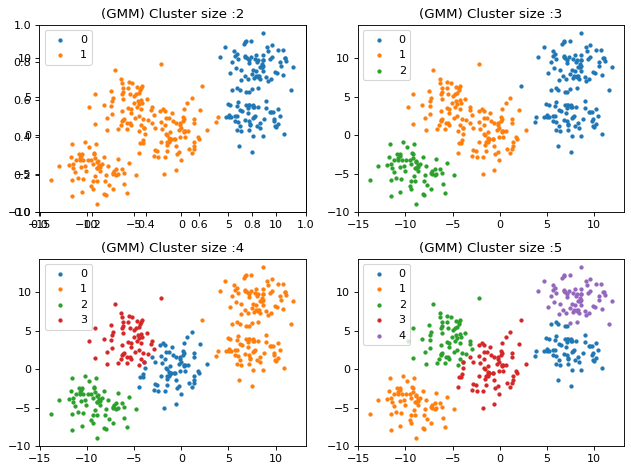

In [944]:
fig = plt.figure(figsize=(8,6),dpi=80)
fig.add_subplot(2,2,1)

for i in range(2,6):
    gm=GaussianMixture(n_components=i).fit(x)
    pred=gm.predict(x)
    df=pd.DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
    groups=df.groupby('label')
    fig.add_subplot(2,2,i-1)
    for name,group in groups:
        plt.scatter(group.x,group.y,label=name,s=8)
        plt.title("(GMM) Cluster size :" + str(i))
        plt.legend()

plt.tight_layout()
plt.show()

Gom cụm sử dụng k-means

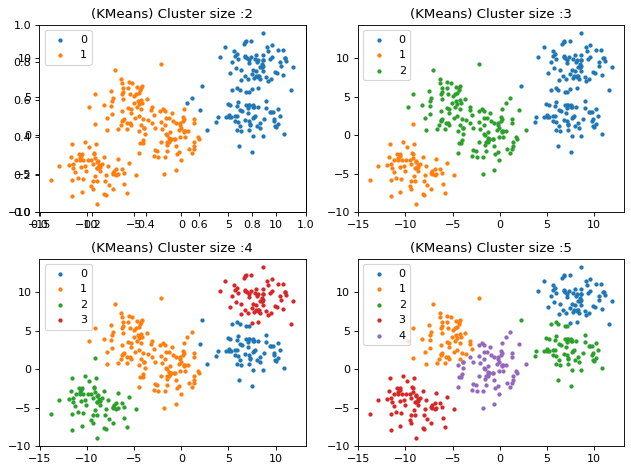

In [945]:
fig = plt.figure(figsize=(8,6),dpi=80)
fig.add_subplot(2,2,1)

for i in range(2,6):
    km=KMeans(n_clusters=i).fit(x)
    pred=km.predict(x)
    df=pd.DataFrame({'x':x[:,0],'y':x[:,1],'label':pred})
    groups=df.groupby('label')
    fig.add_subplot(2,2,i-1)
    for name,group in groups:
        plt.scatter(group.x,group.y,label=name,s=8)
        plt.title("(KMeans) Cluster size :" + str(i))
        plt.legend()

plt.tight_layout()
plt.show()

## **Thuật toán Mahalanobis k-means**

### **Bước 1**: chọn `k` điểm dữ liệu từ dataset để làm cluster ban đầu

Vì Mahalanobis k-means cần gán nhãn cluster tương ứng mỗi điểm dữ liệu ban đầu sử dụng khoảng cách Euclidean nhỏ nhất hay chính là thuật toán k-means gốc

In [946]:
def initiate_centroids_clusters(k,dset, random_state = 234):
    km=KMeans(n_clusters = k,max_iter =1,random_state = random_state)

    # Lấy iter = 1 , nghĩa là chỉ khởi tạo bước lặp đầu tiên bằng thuật toán kmeans
    km.fit(dset)
    clusters=km.labels_

    centroids=pd.DataFrame(km.cluster_centers_,columns=km.feature_names_in_)

    return clusters, centroids

### **Bước 2**: tính khoảng cách `Mahanalobis` từ tâm cụm đến các điểm dữ liệu và gán mỗi điểm dữ liệu cho cụm gần nhất

Khoảng cách Mahanalobis có công thức:

$$D_{Maha} (X, \mu_{r},\Sigma_{r}) = \sqrt{(X-\mu_{r})\Sigma^{-1}(X-\mu_{r})^{T}}$$

- X: mỗi điểm dữ liệu trong dataset (các hàng trong df)
- $\mu_{r}$: tâm cụm r trong danh sách tâm cụm
- $\Sigma_{r}$: ma trận hiệp phương sai ứng với mỗi tâm cụm r

Hàm tính khoảng cách Mahanolobis

In [947]:
def mahalanobis_error(X, mu, sigma):
    ''''
    D(X,mu,sigma)^2 = (X-mu) * Sigma^-1 * (X - mu).T
    '''
    sigma_inv = np.linalg.inv(sigma)
    return np.sqrt((X - mu) @ sigma_inv @ (X - mu).T)

Gán lại các điểm dữ liệu với tâm cụm dựa vào khoảng cách Mahanolobis

In [948]:
def calculate_covariance_matrices(dset,k):
    cov_matrices = []
    for centroid in range(k):
        cov_matrix = np.cov(dset.loc[dset['centroid']==centroid,['x','y']],rowvar=False)
        cov_matrices.append(cov_matrix)
    return cov_matrices

In [949]:
def centroid_assignation(dset, centroids):
    # Số  centroid
    k = centroids.shape[0]

    # Số samples trong tập dữ liệu
    n = dset.shape[0]

    assignation = []

    assign_errors = []

    cov_matrixs =[]
    
    # Tính ma trận hiệp phương sai cho từng cụm
    cov_matrices = calculate_covariance_matrices(dset,k)

    for obs in range(n):
        # List error cho từng centroid
        all_errors = np.array([])

        # Tính error cho từng centroid
        for centroid in range(k):
            err = mahalanobis_error(centroids.iloc[centroid,:], dset.iloc[obs, :2],cov_matrices[centroid])
            all_errors = np.append(all_errors, err)
        # Chọn centroid gần nhất 
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

### **Bước 3**: lặp lại bước 2 cho đến khi các cụm không thay đổi

#### **Visualization** 

In [950]:
def show_plot(ax, df, centroids, title="After Mahalanobis K-means"):
    k = centroids.shape[0]
    scatter_points = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], marker='o', c=df['centroid'].astype('category'), cmap='viridis', s=80, alpha=0.5)
    scatter_centroids = ax.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], marker='X', s=250, c=[i for i in range(k)], cmap='viridis', edgecolors='deeppink')
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

    legend_labels = [f'Centroid {i+1}: ({centroids.iloc[i, 0]:.2f}, {centroids.iloc[i, 1]:.2f})' for i in range(k)]
    legend_elements = scatter_centroids.legend_elements()[0]
    ax.legend(legend_elements, legend_labels, title='Centroids', loc='upper left')


#### **Hàm chính** 

In [951]:
def mahalanobis_kmeans(dset, k = 2, tol = 1e-4, plot = False):
    # Tạo bản sao để tránh thay đổi data gốc
    working_dset = dset.copy()

    # Danh sách error cho từng bước lặp
    err = []

    # Biến điều kiện để tiếp tục vòng lặp
    goahead = True

    # Biến đếm số lần lặp
    j = 0
    
    # Gán giá trị khởi tạo cho centroids
    working_dset['centroid'],centroids=initiate_centroids_clusters(k,working_dset)
    while goahead:
        # Gán centroid và tính error cho các quan sát
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)

        # Tính tổng error và vẽ đồ thị
        err.append(sum(j_err))

        # Tính các centroid mới dựa trên các quan sát đã gán nhãn
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop=True)

        if j > 0:
            if err[j-1] - err[j] <= tol:
                goahead = False

        j += 1

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        show_plot(ax,working_dset,centroids)

    return working_dset['centroid'], j_err, centroids

## **Kết quả**

### Kết quả thuật toán

In [952]:
np.random.seed(234)
x,y=make_blobs(n_samples=330, centers=5,cluster_std=1.84)
df = pd.DataFrame({'x':x[:,0],'y':x[:,1]})

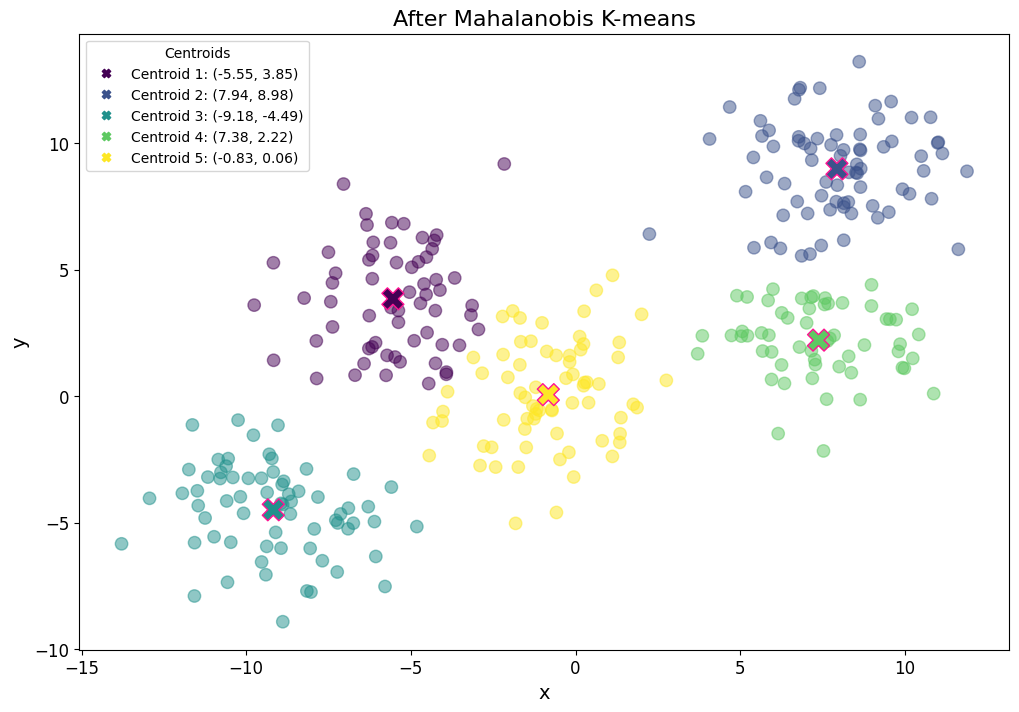

In [953]:
df['centroid'],df['error'],centroids=mahalanobis_kmeans(df,k=5, plot = True)

### So sánh kết quả với các thuật toán khác

Chuẩn bị dữ liệu

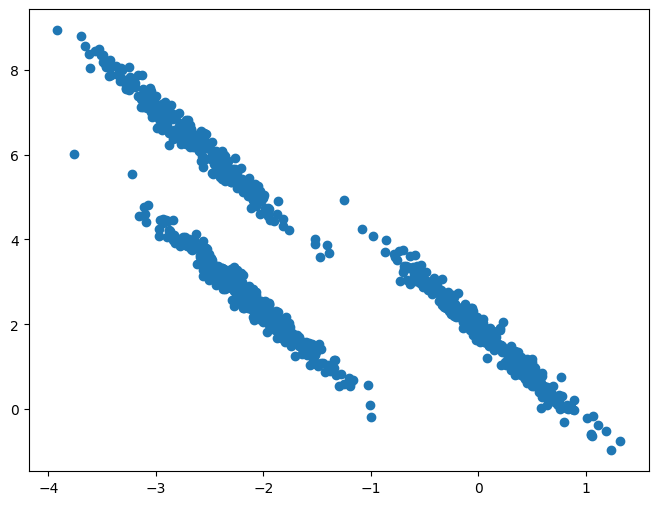

In [954]:
x, y = make_blobs(n_samples=1000, random_state=234,centers=3)
x = np.dot(x, [[0.2, -0.6], [-0.4, 0.8]])
df=pd.DataFrame({'x':x[:,0],'y':x[:,1]})

plt.figure(figsize=(8,6))
plt.scatter(x[:,0],x[:,1])
plt.show()

Áp dụng với k-means và GMM

In [955]:
# Apply standard KMeans
kmeans = KMeans(n_clusters=3, random_state=234)
df['centroid'] = kmeans.fit_predict(df[['x', 'y']])
centroids_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=['x', 'y'])

# Apply GMM
gmm = GaussianMixture(n_components=3, random_state=234)
df['centroid_gmm'] = gmm.fit_predict(df[['x', 'y']])
centroids_gmm = pd.DataFrame(gmm.means_, columns=['x', 'y'])

Vẽ plot

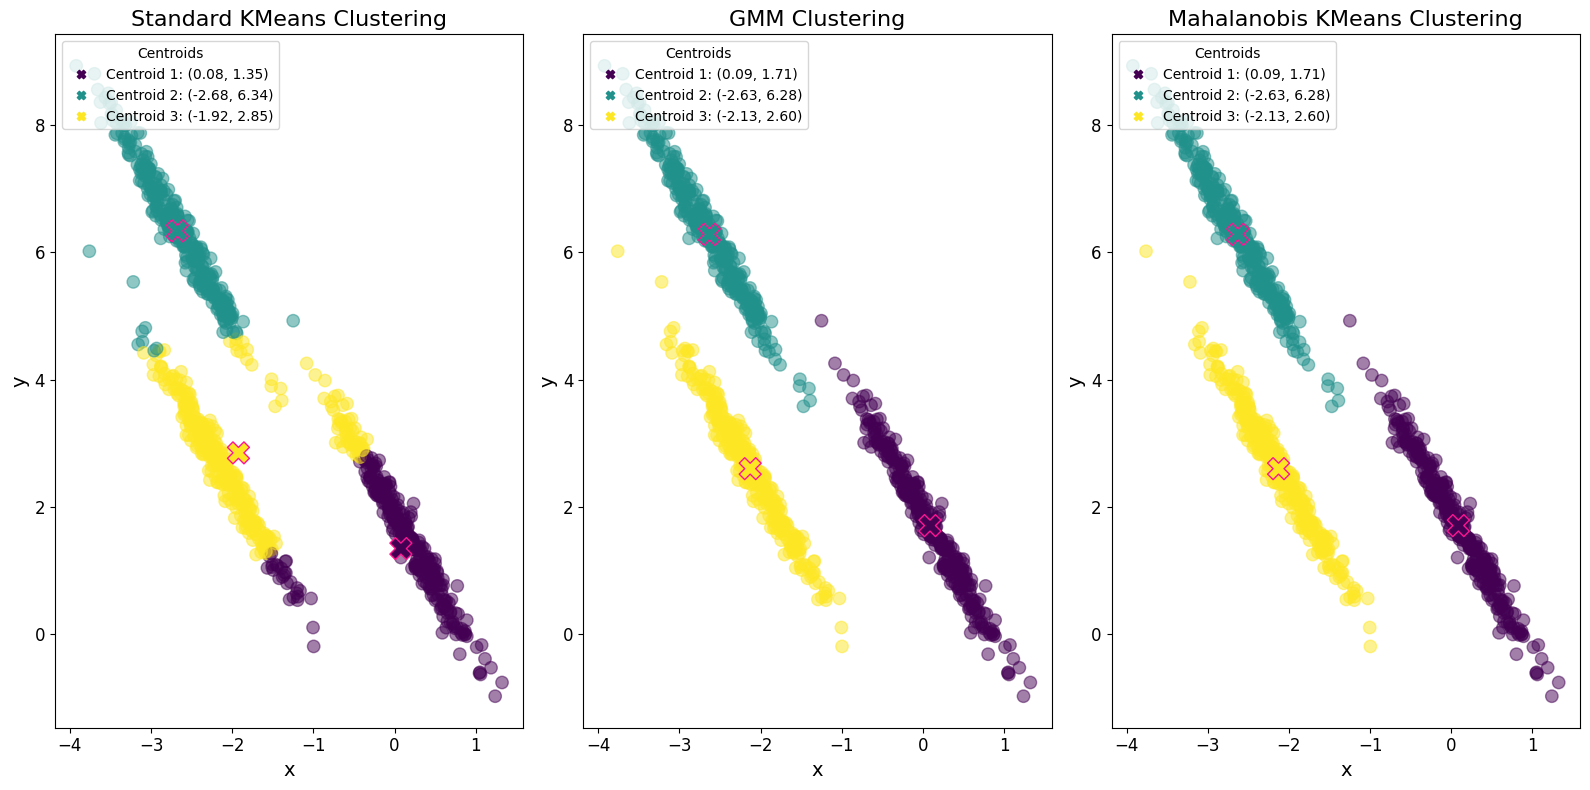

In [956]:
# Mahalanobis KMeans (assuming mahalanobis_kmeans is defined)
df['centroid_maha'], _, centroids_maha_kmeans = mahalanobis_kmeans(df[['x', 'y']], k=3, plot=False)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot for Standard KMeans
df['centroid'] = kmeans.fit_predict(df[['x', 'y']])
show_plot(axs[0], df[['x', 'y', 'centroid']], centroids_kmeans, title='Standard KMeans Clustering')

# Plot for GMM
df['centroid'] = df['centroid_gmm']  # Assign centroid_gmm to centroid for consistent plotting
show_plot(axs[1], df[['x', 'y', 'centroid']], centroids_gmm, title='GMM Clustering')

# Plot for Mahalanobis KMeans
df['centroid'] = df['centroid_maha']  # Assign centroid_maha to centroid for consistent plotting
show_plot(axs[2], df[['x', 'y', 'centroid']], centroids_maha_kmeans, title='Mahalanobis KMeans Clustering')

plt.tight_layout()
plt.show()


#### Nhận xét

1. `K-means:`

- Không thể hiện rõ các cụm khi dữ liệu có tương quan giữa các biến.

- Sử dụng khoảng cách Euclidean, không tính đến tương quan.
2. `GMM (Gaussian Mixture Models):`

- Thể hiện rõ các cụm khi dữ liệu có tương quan giữa các biến.

- Mô hình hóa dữ liệu bằng các phân phối Gaussian, có thể bắt được cấu trúc tương quan.

3. `Phân cụm dựa trên khoảng cách Mahalanobis:`

- Thể hiện rõ các cụm khi dữ liệu có tương quan giữa các biến.

- Sử dụng khoảng cách Mahalanobis, tính đến cả phương sai và tương quan của các biến.